Matplotlib is building the font cache; this may take a moment.


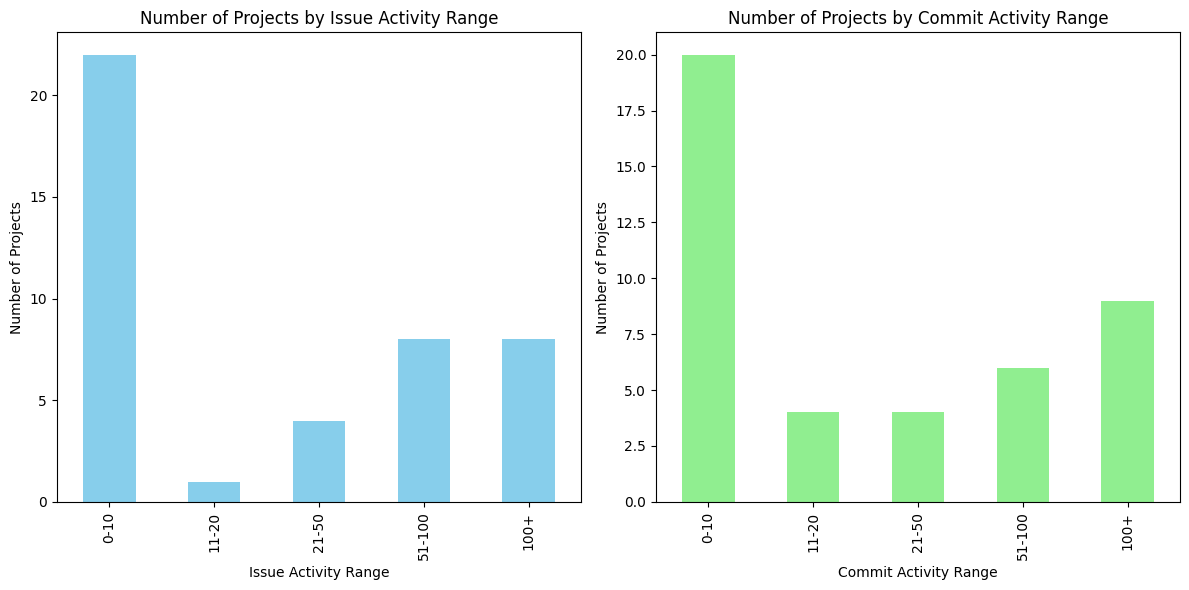

Type,Project_Name,Issue_Activity
SIG,DevOps Automation,264
Project,Common Cloud Controls,223
Project,Accessibility Theme Builder,193
Project,FDC3,170
Project,Git Proxy,156
Project,Common Domain Model,145
SIG,Open source readiness,123
SIG,Diversity Equity & Inclusion Special Interest Group,117
Project,TraderX,97
Project,Morphir,76


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

column_headers = [
    'Score', 'Pass', 'Organisation', 'Repo_Name', 'Finos_Lifecycle_State', 'License',
    'Issue_Activity', 'Commit_Activity', 'OpenSSF_Status', 'Github_Archived',
    'Branch_Rules_Private', 'SemGrep', 'CVE_Scanning', 'Default_Branch_Name', 'Excess_Admins',
    'Main_Issue_Participants', 'Main_Committers', 'Length_of_Readme', 'Project_Name', 'Type', 'Stage'
]

url = 'https://raw.githubusercontent.com/finos-labs/project-analysis/main/scan.csv'
df = pd.read_csv(url, header=0, names=column_headers)


# Remove any rows where 'Project_Name' is equal to the column header 'Project_Name'
df = df[df['Project_Name'] != 'Project Name']

# Convert relevant columns to numeric and handle errors
numeric_columns = ['Score', 'Issue_Activity', 'Commit_Activity', 'Length_of_Readme']
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Fill missing numeric values with 0
df[numeric_columns] = df[numeric_columns].fillna(0)

# Group by 'Project_Name' and 'Type', then sum the numeric columns
grouped_df = df.groupby(['Project_Name', 'Type'])[numeric_columns].sum().reset_index()

# Define ranges for issue and commit activity with inclusive bins
issue_bins = [0, 10, 20, 50, 100, float('inf')]
commit_bins = [0, 10, 20, 50, 100, float('inf')]

# Categorize projects into these ranges
grouped_df['Issue_Range'] = pd.cut(grouped_df['Issue_Activity'], bins=issue_bins,
                                   labels=['0-10', '11-20', '21-50', '51-100', '100+'], right=False)
grouped_df['Commit_Range'] = pd.cut(grouped_df['Commit_Activity'], bins=commit_bins,
                                    labels=['0-10', '11-20', '21-50', '51-100', '100+'], right=False)

# Count the number of projects in each range
issue_range_counts = grouped_df['Issue_Range'].value_counts().sort_index()
commit_range_counts = grouped_df['Commit_Range'].value_counts().sort_index()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Issue Activity Range': issue_range_counts.index,
    'Number of Projects (Issue Activity)': issue_range_counts.values,
    'Commit Activity Range': commit_range_counts.index,
    'Number of Projects (Commit Activity)': commit_range_counts.values
})

# Add a total row
total_row = pd.DataFrame({
    'Issue Activity Range': ['Total'],
    'Number of Projects (Issue Activity)': [issue_range_counts.sum()],
    'Commit Activity Range': ['Total'],
    'Number of Projects (Commit Activity)': [commit_range_counts.sum()]
})

summary_df = pd.concat([summary_df, total_row], ignore_index=True)

from IPython.display import display, HTML

# Top 20 projects by issue activity
top_20_issues = grouped_df[['Type', 'Project_Name', 'Issue_Activity']].sort_values(by='Issue_Activity',
                                                                                   ascending=False).head(20)

# Top 20 projects by commit activity
top_20_commits = grouped_df[['Type', 'Project_Name', 'Commit_Activity']].sort_values(by='Commit_Activity',
                                                                                     ascending=False).head(20)

# Projects with issue activity below 10, sorted in descending order
bottom_issues = grouped_df[['Type', 'Project_Name', 'Issue_Activity']].loc[
    grouped_df['Issue_Activity'] < 10].sort_values(by='Issue_Activity', ascending=False)

# Projects with commit activity below 10, sorted in descending order
bottom_commits = grouped_df[['Type', 'Project_Name', 'Commit_Activity']].loc[
    grouped_df['Commit_Activity'] < 10].sort_values(by='Commit_Activity', ascending=False)

# Convert dataframes to HTML tables
top_20_issues_html = top_20_issues.to_html(index=False)
top_20_commits_html = top_20_commits.to_html(index=False)
bottom_issues_html = bottom_issues.to_html(index=False)
bottom_commits_html = bottom_commits.to_html(index=False)

# Plotting bar charts for issue and commit activity ranges

plt.figure(figsize=(12, 6))

# Bar chart for issue activity ranges
plt.subplot(1, 2, 1)
issue_range_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Projects by Issue Activity Range')
plt.xlabel('Issue Activity Range')
plt.ylabel('Number of Projects')

# Bar chart for commit activity ranges
plt.subplot(1, 2, 2)
commit_range_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Projects by Commit Activity Range')
plt.xlabel('Commit Activity Range')
plt.ylabel('Number of Projects')

plt.tight_layout()
plt.show()

# Displaying the tables side by side
html_content = f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin-right: 20px;">
        <h3>Top 20 Projects by Issue Activity</h3>
        {top_20_issues_html}
    </div>
    <div>
        <h3>Top 20 Projects by Commit Activity</h3>
        {top_20_commits_html}
    </div>
</div>
<br>
<div style="display: flex; justify-content: space-around;">
    <div style="margin-right: 20px;">
        <h3>Projects with Issue Activity Below 10</h3>
        {bottom_issues_html}
    </div>
    <div>
        <h3>Projects with Commit Activity Below 10</h3>
        {bottom_commits_html}
    </div>
</div>
"""

# Display the tables
display(HTML(html_content))